## preparing TA snRNA dataset using Scanpy

In [1]:
import scanpy as sc
import anndata as ad
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import os
import pandas as pd
import sys

In [2]:
# load anndata objects
data_dir = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/seurat_outs/objects/'
all_samples_path = os.path.join(data_dir, 'major_celltype_seurat.h5ad')
adata = ad.read(all_samples_path)
adata

/ocean/projects/cis240075p/asachan/.conda/envs/celloracle/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 40106 × 20513
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition'
    var: 'highly_variable'
    uns: 'harmony', 'pca'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs', 'harmony'
    layers: 'counts'
    obsp: 'nn', 'snn'

In [3]:
adata.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,log10GenesPerUMI,seurat_clusters,RNA_snn_res.0.6,cell_type,condition
F7_KO_AAACCCAAGATTCGAA-1,F7_KO,4350.0,1839,0.781609,0.897236,1,1,Fast IIX,KO
F7_KO_AAACCCACACTCATAG-1,F7_KO,3258.0,1437,1.381215,0.898805,0,0,Fast IIB,KO
F7_KO_AAACCCACAGCCTTCT-1,F7_KO,5633.0,2080,0.479148,0.884717,1,1,Fast IIX,KO
F7_KO_AAACCCACAGTATGAA-1,F7_KO,5423.0,2025,0.976778,0.885550,1,1,Fast IIX,KO
F7_KO_AAACCCACATCATTGG-1,F7_KO,2051.0,1085,2.291565,0.916504,1,1,Fast IIX,KO


In [6]:
ko_adata_subset = adata[adata.obs['condition'] == 'KO']
wt_adata_subset = adata[adata.obs['condition'] == 'WT']

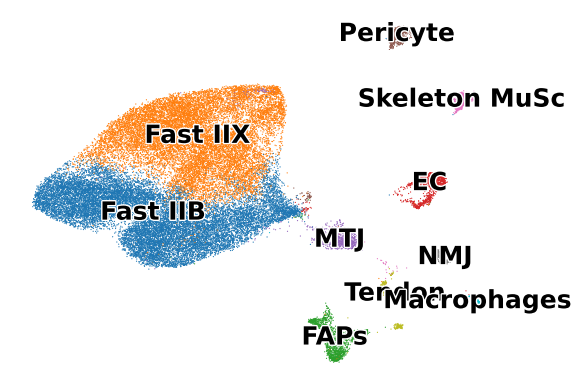

In [11]:
#umap colors by both cell metadata and var.names (gene_names)
sc.pl.umap(adata, color=['cell_type'], frameon=False, legend_fontsize=18,
           legend_fontweight='bold', legend_fontoutline=2, title='', legend_loc='on data')

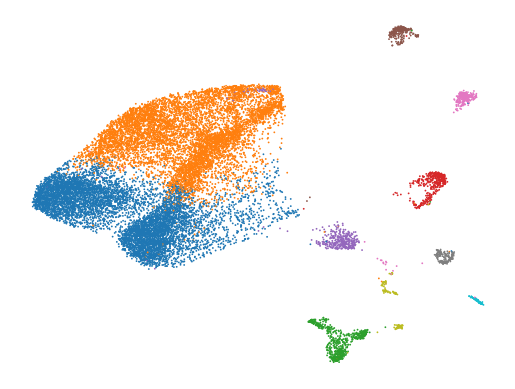

In [16]:
#umap colors by both cell metadata and var.names (gene_names)
sc.pl.umap(wt_adata_subset, color=['cell_type'], frameon=False, title='', show=True, legend_loc=None)

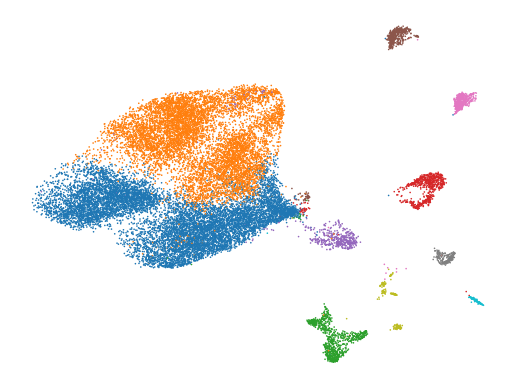

In [17]:
#umap colors by both cell metadata and var.names (gene_names)
sc.pl.umap(ko_adata_subset, color=['cell_type'], frameon=False, title='', show=True, legend_loc=None)

#### Filter mt- ribosomal and other non variable genes

In [75]:
import logging

adata.var_names = [gene.upper() for gene in adata.var_names]
logging.info('Only consider genes with more than 3 counts')
sc.pp.filter_genes(adata, min_counts=3)
logging.info('Normalize gene expression matrix with total UMI count per cell')
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
# Filter for mitochondrial, linc, rps and rpl genes
logging.info('Filtering the data for MT, linc, rps and rpl genes')
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var_names = [gene.upper() for gene in adata.var_names]
adata = adata[:,(~adata.var['mt'])]

#around 100 genes are removed for ERCC1 KO mice data

In [76]:
adata

View of AnnData object with n_obs × n_vars = 40106 × 20403
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'n_counts_all'
    var: 'highly_variable', 'n_counts', 'mt', 'linc', 'rps', 'rpl'
    uns: 'harmony', 'pca', 'cell_type_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs', 'harmony'
    layers: 'counts'
    obsp: 'nn', 'snn'

In [77]:
# Select top 3000 highly-variable genes, don't subset the adata yet, as we'll add in genes of interest back later
filter_result = sc.pp.filter_genes_dispersion(adata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=3000,
                                              log=False)
# this returns a boolean mask that we can use to subset the adata

In [78]:
adata

View of AnnData object with n_obs × n_vars = 40106 × 20403
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'n_counts_all'
    var: 'highly_variable', 'n_counts', 'mt', 'linc', 'rps', 'rpl'
    uns: 'harmony', 'pca', 'cell_type_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs', 'harmony'
    layers: 'counts'
    obsp: 'nn', 'snn'

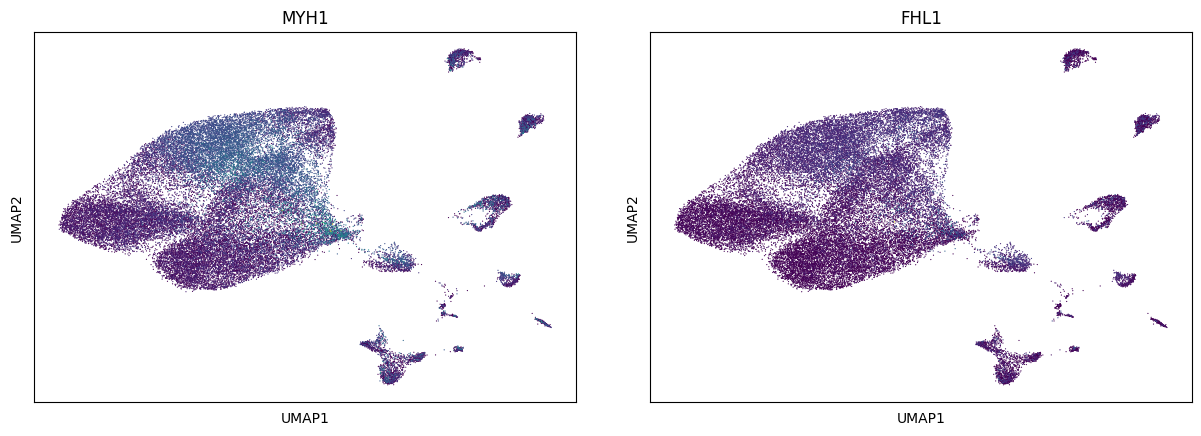

<Figure size 640x480 with 0 Axes>

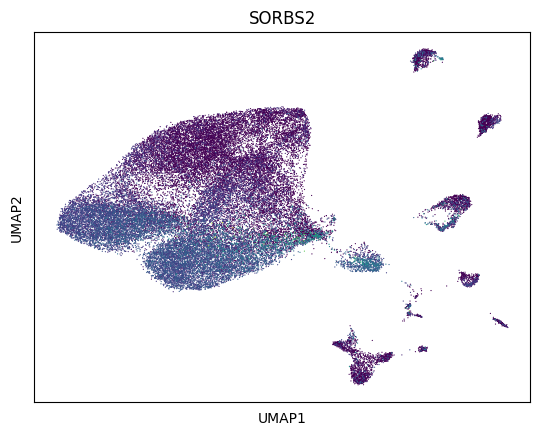

<Figure size 640x480 with 0 Axes>

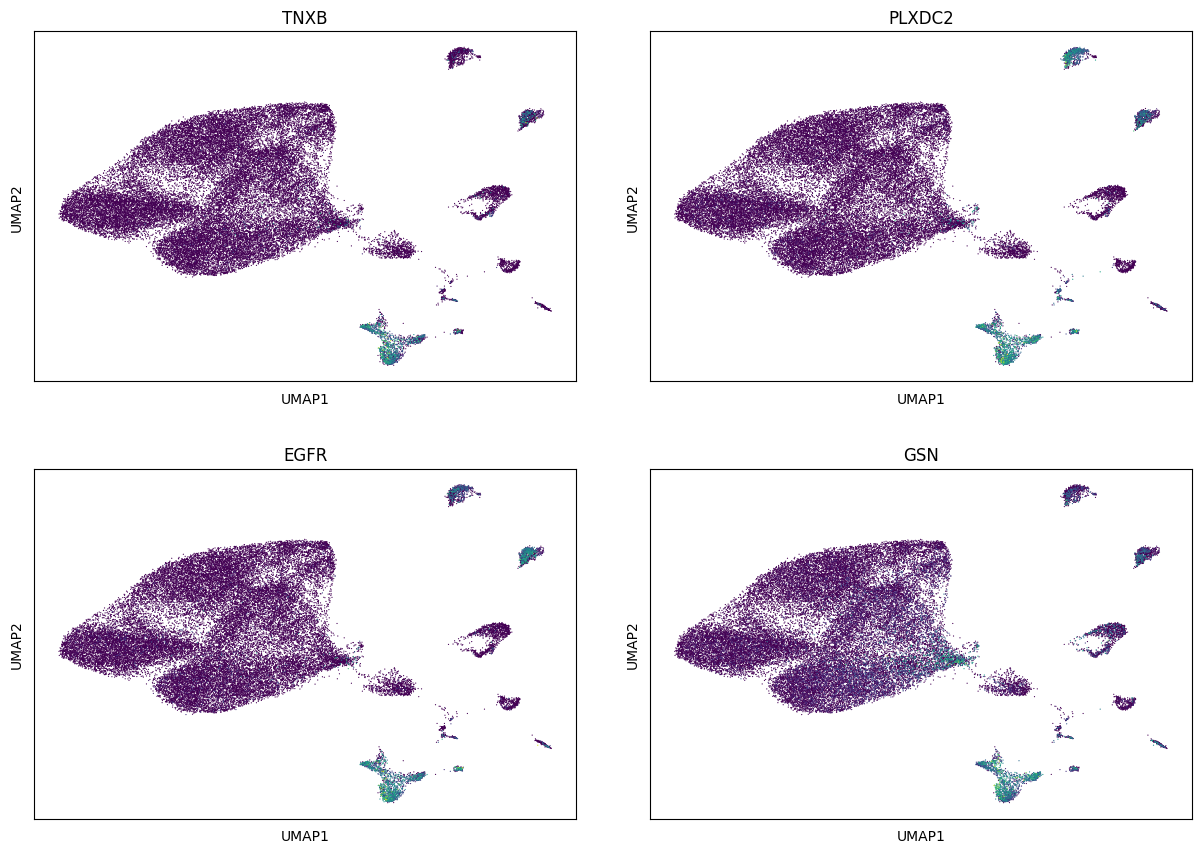

<Figure size 640x480 with 0 Axes>

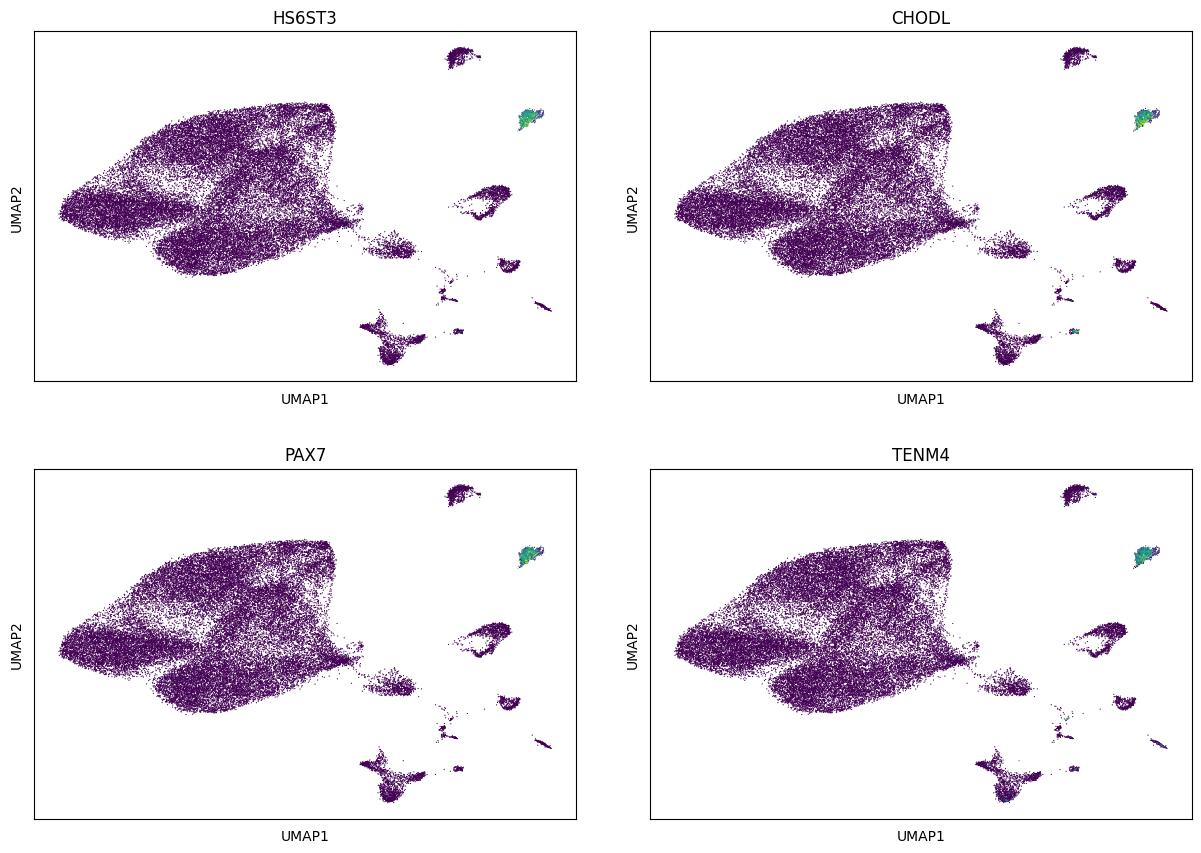

<Figure size 640x480 with 0 Axes>

In [79]:
# after filtering, check for marker genes (as these should be present in highly vairable genes)
import matplotlib.pyplot as plt
# convert all gene names to upper case
adata.var_names = [gene.upper() for gene in adata.var_names]
# specify a save directory for figures
save_folder = '/ocean/projects/cis240075p/asachan/bio_informatics_analysis/TA_muscle_mouse_analysis/figures/'
markers = {
    "Fast IIX": ["MYH1", "FHL1"],
    "Fast IIB": ["SORBS2"],
    "FAPs": ["TNXB", "PLXDC2", "EGFR", "GSN"],
    "Skeleton MuSc": ["HS6ST3", "CHODL", "PAX7", "TENM4"]
}
os.makedirs(f"{save_folder}/marker/", exist_ok=True)
for cell_type, genes in markers.items():
    logging.info(f"Marker gene of {cell_type}")
    sc.pl.umap(adata, color=genes, use_raw=False, ncols=2,colorbar_loc=None,save=False) ## scanpy save sucksss. Use plt.savefig instead
    plt.savefig(f"{save_folder}/marker/umap_marker_genes_{cell_type}.pdf")

#### Check if genes of interest are present in the highly variable ones, if not then convert the bool value to make them.

In [80]:
# MODIFY FILTERED_GENES TO ADD GENES OF INTEREST
# Overriding the bool_list to include TF of interest
bool_list=list(adata.var.index)
gene_list = ["ERCC1", "CDKN2A", "CDKN1A", "MYH8", "MALAT1", "ATP2A1", "EDA2R", "LRRK2", "COL19A1"]

for gene in gene_list:
    try:
        if filter_result.gene_subset[bool_list.index(gene)]==False :
            filter_result.gene_subset[bool_list.index(gene)] = True
    except ValueError:
        print(f"{gene} not in the list")
        continue

# Subset the genes
adata = adata[:, filter_result.gene_subset]
# Renormalize after filtering
sc.pp.normalize_per_cell(adata)
# keep raw count data before log transformation
adata.raw = adata
adata.layers["norm_count"] = adata.raw.X.copy()

CDKN2A not in the list


/ocean/projects/cis240075p/asachan/.conda/envs/celloracle/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:569: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


#### Get separate GRNs for each sample (for comparison b/w WT and seeing if in-silico perturb data matches ERCC1 perturbation)

In [81]:
#display head of orig.ident obs column
adata.obs['orig.ident'].head()

F7_KO_AAACCCAAGATTCGAA-1    F7_KO
F7_KO_AAACCCACACTCATAG-1    F7_KO
F7_KO_AAACCCACAGCCTTCT-1    F7_KO
F7_KO_AAACCCACAGTATGAA-1    F7_KO
F7_KO_AAACCCACATCATTGG-1    F7_KO
Name: orig.ident, dtype: category
Categories (4, object): ['F7_KO', 'F15_WT', 'M4_KO', 'M11_WT']

In [19]:
# get sample specific anndata objects
adata_F_KO = adata[adata.obs['orig.ident'] == 'F7_KO']
adata_F_WT = adata[adata.obs['orig.ident'] == 'F15_WT']
adata_M_KO = adata[adata.obs['orig.ident'] == 'M4_KO']
adata_M_WT = adata[adata.obs['orig.ident'] == 'M11_WT']

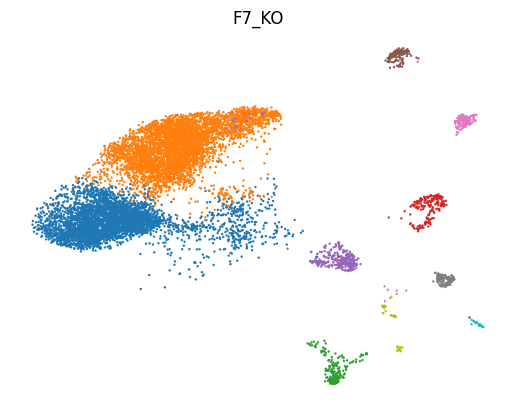

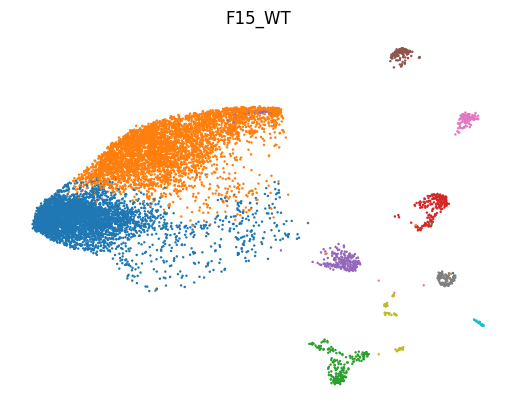

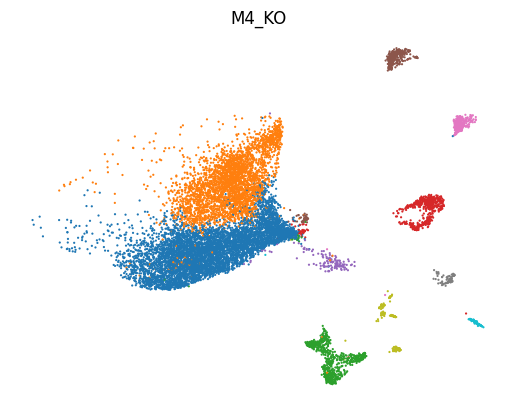

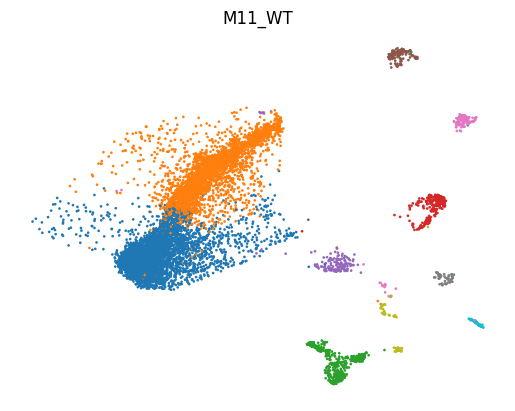

In [20]:
# plot umap for each sample
sc.pl.umap(adata_F_KO, color=['cell_type'], frameon=False, save=False, title='F7_KO', legend_loc=None)
sc.pl.umap(adata_F_WT, color=['cell_type'], frameon=False, save=False, title='F15_WT', legend_loc=None)
sc.pl.umap(adata_M_KO, color=['cell_type'], frameon=False, save=False, title='M4_KO', legend_loc=None)
sc.pl.umap(adata_M_WT, color=['cell_type'], frameon=False, save=False, title='M11_WT', legend_loc=None)

In [84]:
# save sample specific anndata objects
adata_F_KO.write(os.path.join(data_dir, 'F7_KO.h5ad'))
adata_F_WT.write(os.path.join(data_dir, 'F15_WT.h5ad'))
adata_M_KO.write(os.path.join(data_dir, 'M4_KO.h5ad'))
adata_M_WT.write(os.path.join(data_dir, 'M11_WT.h5ad'))

### Gene expression plots

In [20]:
adata.X = adata.layers['counts']

/tmp/ipykernel_59385/2388371574.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_filtered.obs['condition_celltype'] = adata_filtered.obs['condition'].astype(str) + '_' + adata_filtered.obs['cell_type'].astype(str)


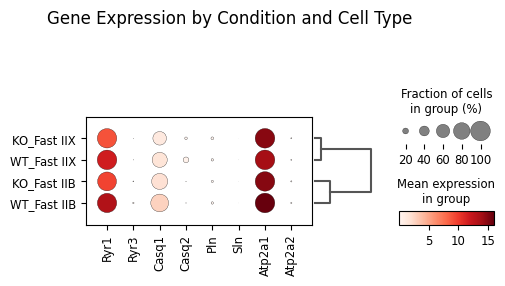

In [21]:
# Non-differentially expressed gene expression (marker genes)
gene_list = ['Ryr1', 'Ryr3', 'Casq1', 'Casq2', 'Pln', 'Sln', 'Atp2a1', 'Atp2a2']
cell_types = ['Fast IIX', 'Fast IIB']

# Filter for specified cell types
adata_filtered = adata[adata.obs['cell_type'].isin(cell_types)]

# Create a new column that combines condition and cell type
adata_filtered.obs['condition_celltype'] = adata_filtered.obs['condition'].astype(str) + '_' + adata_filtered.obs['cell_type'].astype(str)

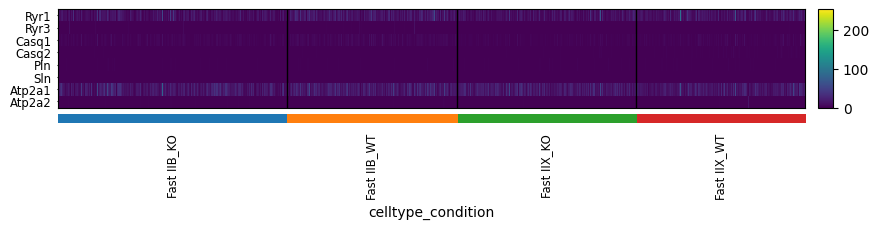

In [22]:
# Create a new column that combines condition and cell type
adata_filtered.obs['celltype_condition'] = adata_filtered.obs['cell_type'].astype(str) + '_' + adata_filtered.obs['condition'].astype(str)
sc.pl.heatmap(adata_filtered, gene_list, groupby='celltype_condition', swap_axes=True)


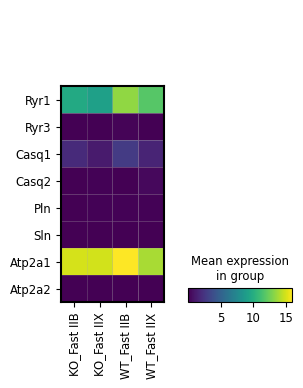

In [23]:
sc.pl.matrixplot(adata_filtered, gene_list, groupby='condition_celltype', swap_axes=True)

In [19]:
print(adata_filtered.X.max())
print(adata_filtered.X.min())

8.492015304906278
0.0


In [ ]:
# Plot all conditions and cell types in one plot
sc.pl.dotplot(adata_filtered, 
              gene_list, 
              groupby='condition_celltype',
              dendrogram=True,
              title='Gene Expression by Condition and Cell Type')